In [2]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

[gpu(id=0)]

# Model Definition

In [23]:
class EuropeanPayoff:
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


In [5]:

# class HestonState
# class MarkovState

@dataclass
class Heston:

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    # def spot_path_lsm(self):
    #     # vols

    #     # vol_path = jnp.zeros_like(vol_draws)
    #     # vol_path = vol_path.at[0].set(self.v0)

    #     v0 = self.v0
    #     v_truncated = jnp.maximum(0.0, v0)
    #     v1 = v0 + self.kappa * T * (self.theta - v_truncated) + self.xi * jnp.sqrt(v_truncated * T) * vol_draws[i-1]

    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
    #         randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
    #         vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

    #     return vol_path


    #     vec_size = len(spot_draws)
    #     dt = self.T / vec_size
    #     spot_paths = jnp.zeros_like(vol_path)
    #     spot_paths = spot_paths.at[0].set(self.S0)

    #     for i in range(1, vec_size):
    #         v_truncated = jnp.maximum(0.0, vol_path[i-1])
    #         path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
    #         spot_paths = spot_paths.at[i].set(path_new_spot)
    #     return spot_paths

    # TODO: store vol_path inside class?
    def spot_path_for_loop(self, spot_draws: Array, vol_path: Array) -> Array:
        vec_size = len(spot_draws)
        dt = self.T / vec_size
        spot_paths = jnp.zeros_like(vol_path)
        spot_paths = spot_paths.at[0].set(self.S0)


        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            path_new_spot = spot_paths[i-1] * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draws[i-1])
            spot_paths = spot_paths.at[i].set(path_new_spot)
        return spot_paths

    def spot_path(self, spot_draws: Array, vol_path: Array) -> Array:
        n_iter = len(spot_draws)
        dt = self.T / n_iter

        def spot_path_iter(prev_spot_path, iter_pair):
            spot_draw = iter_pair[0]
            vol = iter_pair[1]
            v_truncated = jnp.maximum(0.0, vol)
            path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
            return path_new_spot, path_new_spot

        iter_values = jnp.column_stack((spot_draws, vol_path))
        carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(self.S0), iter_values, length=n_iter)

        spot_paths = jnp.roll(spot_paths.at[-1].set(self.S0), 1)
        return spot_paths

    def volatility_path_for_loop(self, vol_draws: Float[Array, "n ..."]) -> Float[Array, "n ..."]:
        vec_size = len(vol_draws)
        dt = self.T / vec_size

        vol_path = jnp.zeros_like(vol_draws)
        vol_path = vol_path.at[0].set(self.v0)

        for i in range(1, vec_size):
            v_truncated = jnp.maximum(0.0, vol_path[i-1])
            prev_path_contribution = vol_path[i-1] + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draws[i-1]
            vol_path = vol_path.at[i].set(prev_path_contribution + randomness)

        return vol_path

    def volatility_path(self, vol_draws):
        n_iter = len(vol_draws)
        dt = self.T / n_iter

        def vol_path_iter(prev_vol_path, vol_draw):
            v_truncated = jnp.maximum(0.0, prev_vol_path)
            prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
            randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
            current = prev_path_contribution + randomness
            return current, current # use current both for carry and for y

        carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)

        # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
        vol_path = jnp.roll(vol_path.at[-1].set(self.v0), 1)
        return vol_path

    def path(self, key: PRNGKeyArray, n_intervals: int = 1000):
        mean = jnp.zeros(2)
        cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

        correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_intervals,))

        vol_draws = correlated_samples[:, 0]
        spot_draws = correlated_samples[:, 1]

        vol_path = self.volatility_path(vol_draws)
        spot_path = self.spot_path(spot_draws, vol_path)
        return vol_path, spot_path

    def payoff(self, key: PRNGKeyArray, n_intervals: int = 1000, payoff_fn = EuropeanPayoff.call):
        _, spot_path = self.path(key, n_intervals)
        spot_maturity = spot_path[-1]
        payoff = payoff_fn(spot_maturity, self.K)
        return payoff


# Exploration

In [6]:
n_sims : int = 1000000
n_intervals: int = 1000
heston = Heston()

In [7]:
key = jrandom.PRNGKey(0)

key, subkey = jrandom.split(key)
vol_draws = jrandom.normal(key=subkey, shape=(100, ))
# print(vol_draws)

vol_path_for = heston.volatility_path_for_loop(vol_draws)
vol_path = heston.volatility_path(vol_draws)
assert(jnp.allclose(vol_path_for, vol_path))

In [8]:
key, subkey = jrandom.split(key)
spot_draws = jrandom.normal(key=subkey, shape=(100, ))

spot_path_for = heston.spot_path_for_loop(spot_draws, vol_path)
spot_path = heston.spot_path(spot_draws, vol_path)
assert(jnp.allclose(spot_path_for, spot_path))

In [9]:
key, subkey = jrandom.split(key)

mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)
correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(100000,))
correlated_samples.shape

[[ 1.  -0.3]
 [-0.3  1. ]]


(100000, 2)

In [10]:
sample_mean = jnp.mean(correlated_samples, axis=0)
assert(jnp.allclose(sample_mean, mean, atol=1e-2))

In [11]:
sample_cov = jnp.cov(correlated_samples.T)
assert(jnp.allclose(sample_cov, cov, atol=1e-2))

In [12]:
jnp.corrcoef(correlated_samples.T)[0, 1]

Array(-0.30700636, dtype=float64)

In [13]:
jnp.corrcoef(correlated_samples[:, 0], correlated_samples[:, 1])

Array([[ 1.        , -0.30700636],
       [-0.30700636,  1.        ]], dtype=float64)

In [14]:
mean = jnp.zeros(2)
cov = jnp.array([[1, heston.rho], [heston.rho, 1]])

print(cov)

[[ 1.  -0.3]
 [-0.3  1. ]]


# Price

In [15]:
# Price calculation of heston model on european call option
def price(key):
    n_multiplier = 1
    n_simulations = 1000000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    key, subkey = jrandom.split(key)

    def pathwise_payoff_fn(payoff_sum, key):
        keys = jrandom.split(key, num=n_sims_per_iter)
        pathwise_payoff = vmap(heston.payoff)(keys)

        payoff_sum_iter = jnp.sum(pathwise_payoff)
        payoff_sum += payoff_sum_iter
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(subkey, num=n_outside_iter)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, 0.0, keys, length=n_outside_iter)

    price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    jax.debug.print("price {}", price)


In [16]:
key = jrandom.PRNGKey(0)
heston = Heston()

In [17]:
price_fn = jit(price)

In [72]:
%timeit price_fn(key)

price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
price 34.93229832368327
8.99 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
price_fn(key)

price 34.93229832368327


# Visualize Data

In [24]:
n_sims : int = 100000
n_intervals: int = 1000
heston = Heston()

In [30]:
heston_payoff_fn = jit(vmap(heston.payoff))

In [31]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)

payoffs = heston_payoff_fn(keys)
print(payoffs.shape)

(100000,)


In [32]:
heston_paths_fn = jit(vmap(heston.path))

In [36]:
key, subkey = jrandom.split(key)
keys = jrandom.split(key, num=n_sims)
vol_paths, spot_paths = heston_paths_fn(keys)


print(spot_paths[..., -1].shape)
print(spot_paths.shape)
print(spot_paths)
pathwise_payoff = EuropeanPayoff.payoff(spot_paths, heston.K)

print(pathwise_payoff)
print(pathwise_payoff.shape)


(100000,)
(100000, 1000)
[[100.          98.43100014  94.50448194 ...  24.34189295  23.11289191
   22.04966621]
 [100.          97.37876261  97.11160382 ...  20.35443659  20.34570842
   20.52663431]
 [100.         103.67970768 103.78909442 ...  26.02349527  26.12516714
   30.08314914]
 ...
 [100.         100.84983778 100.88391506 ...  35.55724144  35.66480622
   35.4446042 ]
 [100.         101.08009739  97.46910456 ...  96.32388458  96.34796856
   96.37205856]
 [100.          99.1591889   99.78829431 ... 126.41074661 126.58211752
  126.52589298]]
[ 0.          0.          0.         ...  0.          0.
 26.52589298]
(100000,)


In [ ]:
# TODO: generate payoff samples for a bunch of other starting spots. Those spots
#       can either be found via MC or using some grid...
#
#       look into page 19 training inputs

In [42]:
print(spot_paths[:, 0])

[100. 100. 100. ... 100. 100. 100.]


In [43]:
print(pathwise_payoff)

[ 0.          0.          0.         ...  0.          0.
 26.52589298]


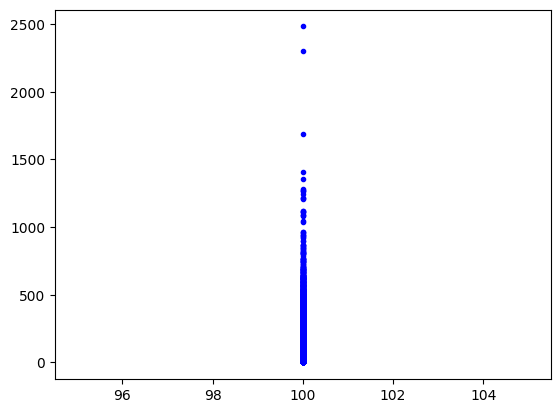

In [44]:
plt.plot(spot_paths[:, 0], pathwise_payoff, "b.")